This notebook illustrates how to apply the transformer metric to a single burst time series. 

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rasterio.plot import show
from scipy.special import expit, logit

from distmetrics import (
    compute_mahalonobis_dist_2d,
    compute_transformer_zscore,
    despeckle_rtc_arrs_with_tv,
    get_asf_rtc_burst_ts,
    load_transformer_model,
    read_asf_rtc_image_data,
)

from distmetrics.asf_burst_search import get_pre_post_df_rtc_df

# Parameters

In [3]:
# Papau New Guinea Landslide -  https://www.cnn.com/2024/05/25/world/video/damage-papua-new-guinea-landslide-ldn-digvid
BURST_ID = "T009_019294_IW2"
EVENT_TS = pd.Timestamp("2024-05-28", tz="utc")

# Los Angeles Angeles Fire - Pacific Palisades Burst
BURST_ID = 'T071-151228-IW3'
EVENT_TS = pd.Timestamp("2025-01-08", tz="utc")

DEVICE =  'cpu'

N_PRE_IMAGES = 20
APPLY_LOGIT = True

N_PRE_IMGS_PER_YEAR = 3

# Download Data

In [4]:
df_rtc_ts = get_asf_rtc_burst_ts(BURST_ID)
print("# of results: ", df_rtc_ts.shape[0])
df_rtc_ts.head()

# of results:  365


/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/asf_burst_search.py:19: UserWarning: No urls found for OPERA_L2_RTC-S1_T071-151228-IW3_20170127T135217Z_20250925T040353Z_S1A_30_v1.0 and polarization crosspol
  warn(f'No urls found for {row.opera_id} and polarization {polarization}')
/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/asf_burst_search.py:19: UserWarning: No urls found for OPERA_L2_RTC-S1_T071-151228-IW3_20170103T135218Z_20250925T193553Z_S1A_30_v1.0 and polarization crosspol
  warn(f'No urls found for {row.opera_id} and polarization {polarization}')
/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/asf_burst_search.py:19: UserWarning: No urls found for OPERA_L2_RTC-S1_T071-151228-IW3_20161210T135220Z_20250928T025053Z_S1A_30_v1.0 and polarization crosspol
  warn(f'No urls found for {row.opera_id} and polarization {polarization}')
/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/asf_burst_search.py:19: UserWarning: No urls found for OPERA_L2_RTC

,opera_id,acq_datetime,polarizations,track_number,geometry,url_crosspol,url_copol,dedup_id
0,OPERA_L2_RTC-S1_T071-151228-IW3_20160426T13521...,2016-04-26 13:52:13+00:00,VV+VH,71,"POLYGON ((-118.25034 34.16192, -119.1051 34.28...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20160426T135213Z
1,OPERA_L2_RTC-S1_T071-151228-IW3_20160520T13521...,2016-05-20 13:52:14+00:00,VV+VH,71,"POLYGON ((-118.25055 34.16236, -119.1053 34.28...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20160520T135214Z
2,OPERA_L2_RTC-S1_T071-151228-IW3_20160731T13521...,2016-07-31 13:52:18+00:00,VV+VH,71,"POLYGON ((-118.25072 34.16242, -119.10541 34.2...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20160731T135218Z
3,OPERA_L2_RTC-S1_T071-151228-IW3_20160824T13521...,2016-08-24 13:52:19+00:00,VV+VH,71,"POLYGON ((-118.25008 34.16163, -119.10485 34.2...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20160824T135219Z
4,OPERA_L2_RTC-S1_T071-151228-IW3_20160917T13522...,2016-09-17 13:52:20+00:00,VV+VH,71,"POLYGON ((-118.25047 34.16148, -119.10524 34.2...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20160917T135220Z


In [5]:
df_prod = get_pre_post_df_rtc_df(df_rtc_ts, 
                                 EVENT_TS,
                                 n_anniversaries=3,
                                 n_pre_imgs=N_PRE_IMAGES)
df_prod.tail()

/Users/cmarshak/miniforge3/envs/distmetrics/lib/python3.13/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,opera_id,acq_datetime,polarizations,track_number,geometry,url_crosspol,url_copol,dedup_id,input_category
16,OPERA_L2_RTC-S1_T071-151228-IW3_20231128T13530...,2023-11-28 13:53:01+00:00,VV+VH,71,"POLYGON ((-118.23321 34.15926, -119.11329 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20231128T135301Z,pre
17,OPERA_L2_RTC-S1_T071-151228-IW3_20231210T13530...,2023-12-10 13:53:01+00:00,VV+VH,71,"POLYGON ((-118.23419 34.15968, -119.1143 34.28...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20231210T135301Z,pre
18,OPERA_L2_RTC-S1_T071-151228-IW3_20231222T13530...,2023-12-22 13:53:00+00:00,VV+VH,71,"POLYGON ((-118.23173 34.15971, -119.11186 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20231222T135300Z,pre
19,OPERA_L2_RTC-S1_T071-151228-IW3_20240103T13530...,2024-01-03 13:53:00+00:00,VV+VH,71,"POLYGON ((-118.23285 34.15929, -119.11293 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20240103T135300Z,pre
20,OPERA_L2_RTC-S1_T071-151228-IW3_20250109T13525...,2025-01-09 13:52:54+00:00,VV+VH,71,"POLYGON ((-118.234 34.15983, -119.11409 34.283...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20250109T135254Z,post


In [6]:
df_prod.acq_datetime.tolist()

[Timestamp('2021-11-26 13:52:51+0000', tz='UTC'),
 Timestamp('2021-12-02 13:52:09+0000', tz='UTC'),
 Timestamp('2021-12-08 13:52:50+0000', tz='UTC'),
 Timestamp('2021-12-14 13:52:08+0000', tz='UTC'),
 Timestamp('2021-12-20 13:52:50+0000', tz='UTC'),
 Timestamp('2022-01-01 13:52:49+0000', tz='UTC'),
 Timestamp('2022-11-09 13:52:57+0000', tz='UTC'),
 Timestamp('2022-11-21 13:52:57+0000', tz='UTC'),
 Timestamp('2022-12-03 13:52:57+0000', tz='UTC'),
 Timestamp('2022-12-15 13:52:56+0000', tz='UTC'),
 Timestamp('2022-12-27 13:52:55+0000', tz='UTC'),
 Timestamp('2023-01-08 13:52:55+0000', tz='UTC'),
 Timestamp('2023-10-11 13:53:02+0000', tz='UTC'),
 Timestamp('2023-10-23 13:53:03+0000', tz='UTC'),
 Timestamp('2023-11-04 13:53:02+0000', tz='UTC'),
 Timestamp('2023-11-16 13:53:02+0000', tz='UTC'),
 Timestamp('2023-11-28 13:53:01+0000', tz='UTC'),
 Timestamp('2023-12-10 13:53:01+0000', tz='UTC'),
 Timestamp('2023-12-22 13:53:00+0000', tz='UTC'),
 Timestamp('2024-01-03 13:53:00+0000', tz='UTC'),


**Warning**: sometime this cell fails and must be re-run due to a transient server error.

In [7]:
# Load only the filtered images (much more memory efficient!)
arrs_vv, profiles = read_asf_rtc_image_data(df_prod.url_copol)
arrs_vh, _ = read_asf_rtc_image_data(df_prod.url_crosspol)

Loading RTC data: 100%|██████████████████████████████████████████| 21/21 [00:19<00:00,  1.06it/s]


In [8]:
arrs_vv_d = despeckle_rtc_arrs_with_tv(arrs_vv, n_jobs=10, interp_method='bilinear')
arrs_vh_d = despeckle_rtc_arrs_with_tv(arrs_vh, n_jobs=10, interp_method='bilinear')

Despeckling: 100%|███████████████████████████████████████████████| 21/21 [02:04<00:00,  5.91s/it]


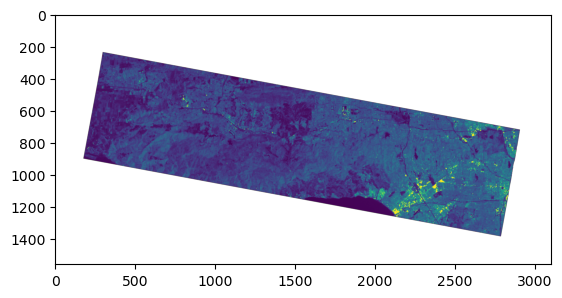

In [9]:
plt.imshow(arrs_vh_d[-1], vmin=0, vmax=.15)

In [10]:
from distmetrics.model_load import ALLOWED_MODELS
ALLOWED_MODELS

['transformer_original',
 'transformer_optimized',
 'transformer_optimized_fine',
 'transformer_anniversary_trained',
 'transformer_anniversary_trained_optimized',
 'transformer_anniversary_trained_optimized_fine',
 'transformer_v0_32',
 'transformer_v1_32']

In [37]:
transformer = load_transformer_model(lib_model_token='transformer_v1_32', device=DEVICE, model_compilation=False)

In [13]:
def apply_logit_func(arr):
    arr_in = arr.copy()
    arr_in[np.isnan(arr_in)] = 1e-7
    return logit(arr_in)

pre_imgs_vv = arrs_vv_d[:-1]
pre_imgs_vh = arrs_vh_d[:-1]
if APPLY_LOGIT:
    pre_imgs_vv = list(map(logit, pre_imgs_vv))
    pre_imgs_vh = list(map(logit, pre_imgs_vh))

In [14]:
post_vv = arrs_vv_d[-1]
post_vh = arrs_vh_d[-1]
if APPLY_LOGIT:
    post_vv = logit(post_vv)
    post_vh = logit(post_vh)

In [15]:
# Landslide
if BURST_ID == "T009_019294_IW2":
    sy = np.s_[1250:1500]
    sx = np.s_[400:750]
    pre_vv_c = [arr[sy, sx] for arr in pre_imgs_vv]
    pre_vh_c = [arr[sy, sx] for arr in pre_imgs_vh]

    post_vv_c = post_vv[sy, sx]
    post_vh_c = post_vh[sy, sx]

else:
    sy = np.s_[:]
    sx = np.s_[:]
    pre_vv_c = [arr[sy, sx] for arr in pre_imgs_vv]
    pre_vh_c = [arr[sy, sx] for arr in pre_imgs_vh]

    post_vv_c = post_vv[sy, sx]
    post_vh_c = post_vh[sy, sx]

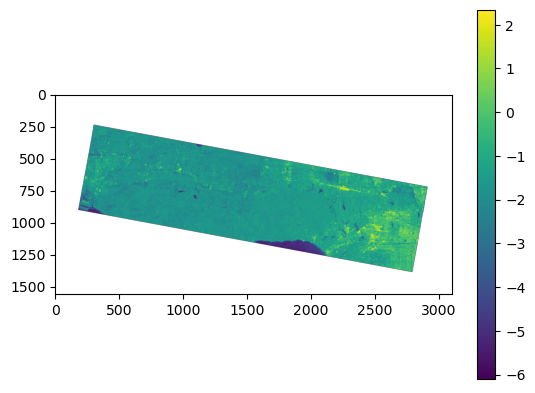

In [16]:
plt.imshow(pre_vv_c[-1])
plt.colorbar()

In [17]:
len(pre_vv_c)

20

In [18]:
# %%memit 

# dist_ob_tiles = compute_transformer_zscore(
#     transformer,
#     pre_vv_c[:10],
#     pre_vh_c[:10],
#     post_vv_c,
#     post_vh_c,
#     stride=16,
#     agg="max",
#     batch_size=512,
#     memory_strategy="high",
#     device=DEVICE,
#     tile_size=512
# )

In [46]:
%%memit 
dist_ob = compute_transformer_zscore(
    transformer,
    pre_vv_c[:],
    pre_vh_c[:],
    post_vv_c,
    post_vh_c,
    stride=27,
    agg="max",
    batch_size=512,
    memory_strategy="high",
    device=DEVICE,
    tile_size=None
)

Chips Traversed:   0%|                                                    | 0/13 [00:00<?, ?it/s]

peak memory: 15488.72 MiB, increment: 4953.95 MiB


In [34]:
%%memit 
dist_ob = compute_transformer_zscore(
    transformer,
    pre_vv_c[:],
    pre_vh_c[:10],
    post_vv_c,
    post_vh_c,
    stride=32,
    agg="max",
    batch_size=512,
    memory_strategy="high",
    device=DEVICE,
    tile_size=None
)

Chips Traversed:   0%|                                                     | 0/9 [00:00<?, ?it/s]

peak memory: 13769.41 MiB, increment: 1207.22 MiB


In [33]:
%%memit 
dist_ob = compute_transformer_zscore(
    transformer,
    pre_vv_c[:],
    pre_vh_c[:],
    post_vv_c,
    post_vh_c,
    stride=32,
    agg="max",
    batch_size=512,
    memory_strategy="high",
    device=DEVICE,
    tile_size=None
)

Chips Traversed:   0%|                                                     | 0/9 [00:00<?, ?it/s]

peak memory: 17220.83 MiB, increment: 4658.64 MiB


In [21]:
%%memit 
dist_ob = compute_transformer_zscore(
    transformer,
    pre_vv_c[:],
    pre_vh_c[:],
    post_vv_c,
    post_vh_c,
    stride=7,
    agg="max",
    batch_size=512,
    memory_strategy="high",
    device=DEVICE,
    tile_size=None
)

Chips Traversed:   0%|                                                   | 0/188 [00:00<?, ?it/s]

Process MemTimer-23:
Traceback (most recent call last):
  File "/Users/cmarshak/miniforge3/envs/distmetrics/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/Users/cmarshak/miniforge3/envs/distmetrics/lib/python3.13/site-packages/memory_profiler.py", line 262, in run
    stop = self.pipe.poll(self.interval)
  File "/Users/cmarshak/miniforge3/envs/distmetrics/lib/python3.13/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
           ~~~~~~~~~~^^^^^^^^^
  File "/Users/cmarshak/miniforge3/envs/distmetrics/lib/python3.13/multiprocessing/connection.py", line 440, in _poll
    r = wait([self], timeout)
  File "/Users/cmarshak/miniforge3/envs/distmetrics/lib/python3.13/multiprocessing/connection.py", line 1148, in wait
    ready = selector.select(timeout)
  File "/Users/cmarshak/miniforge3/envs/distmetrics/lib/python3.13/selectors.py", line 398, in select
    fd_event_list = self._selector.poll(timeout)
K

KeyboardInterrupt: 

In [39]:
dist = dist_ob_tiles.dist

NameError: name 'dist_ob_tiles' is not defined

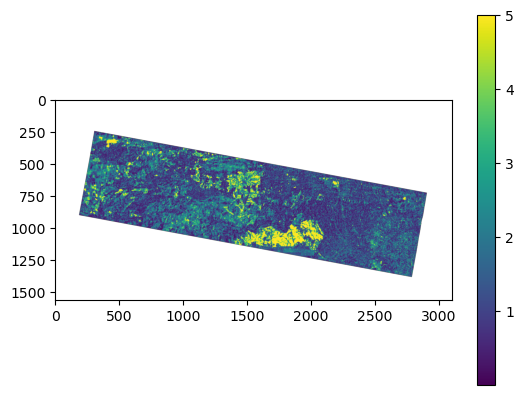

In [48]:
plt.imshow(dist_ob.dist, vmax=5)
plt.colorbar()

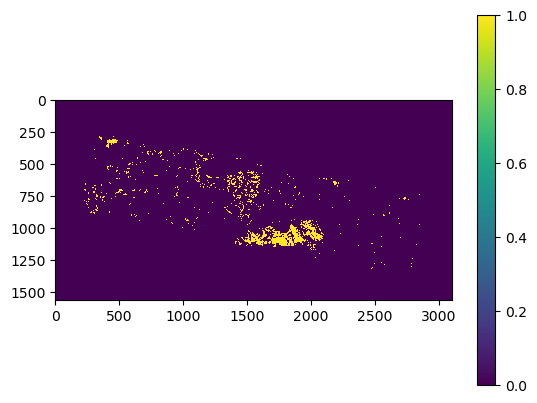

In [49]:
plt.imshow(dist_ob.dist > 4., vmax=1, interpolation="none")
plt.colorbar()

**Warninig**: the stat outputs of the function above are in `logits` NOT `gamma naught`. Hence `expit`!

In [ ]:
from scipy.special import expit

plt.title("Mean Estimate VV ($\gamma$)")
plt.imshow(expit(dist_ob.mean[0, ...]))
plt.colorbar()

Can't really apply `expit` to `sigma`...

In [ ]:
plt.title("Std Estimate logit(VV)")
plt.imshow(dist_ob.std[0, ...], vmax=1, vmin=0)
plt.colorbar()

In [ ]:
dist.shape, dist_ob.dist

In [ ]:
import rasterio

with rasterio.open('dist.tif', 'w', **profiles[0]) as ds:
    ds.write(dist, 1)

In [ ]:
import rasterio

with rasterio.open('dist_og.tif', 'w', **profiles[0]) as ds:
    ds.write(dist_ob.dist, 1)

In [ ]:
import rasterio

with rasterio.open('dist_diff.tif', 'w', **profiles[0]) as ds:
    ds.write(dist_ob.dist - dist, 1)